In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Usage example
image1 = cv2.imread('Harris_Boundary.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('masks_test.png', cv2.IMREAD_GRAYSCALE)

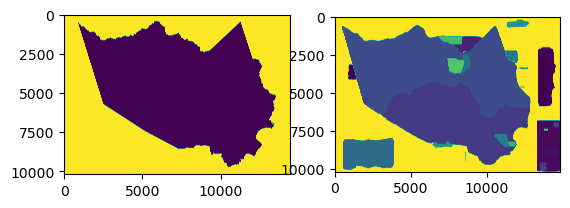

In [5]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(image1)
axs[1].imshow(image2)

In [51]:
# Detect keypoints and compute descriptors for the images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

In [60]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors1,descriptors2,k=2)

In [65]:
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(image1,keypoints1,image2,keypoints2,matches,None,**draw_params)

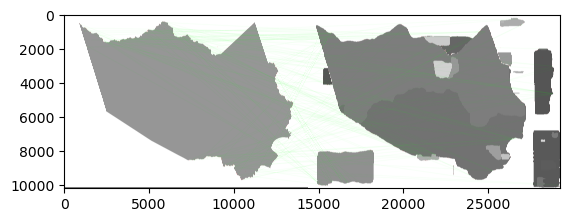

In [66]:
plt.imshow(img3)

In [68]:
# Estimate the transformation matrix using RANSAC
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [57]:

draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_DEFAULT)

# img3 = cv2.drawMatches(image1, keypoints1, 
#                       image2, keypoints2, 
#                       matches, 
#                       None, 
#                       **draw_params)

img3 = cv2.drawMatchesKnn(image1,keypoints1,
                         image2,keypoints2,
                         good_matches,None,
                         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'drawMatchesKnn'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type


In [41]:
def draw_rectangle(image1, image2, transform_matrix):
    # Get the shape of image 2
    height, width = image2.shape[:2]

    # Define the corners of the rectangle in image 2
    corners = np.float32([[0, 0, 1], [0, height, 1], [width, height, 1], [width, 0, 1]])
    
    print(corners)
    
    # Warp the corners of the rectangle using the transformation matrix
    # transformed_corners = cv2.perspectiveTransform(corners, transform_matrix)
    
    transformed_corners = corners @ transform_matrix.T
    
    print(transformed_corners)
    
    # Draw the rectangle on image 1
    image1_with_rectangle = cv2.polylines(image2, [np.int32(transformed_corners)], True, (0, 255, 0), 2)

    return image1_with_rectangle

image_with_rect = draw_rectangle(image1, image2, M)

[[0.0000e+00 0.0000e+00 1.0000e+00]
 [0.0000e+00 1.0205e+04 1.0000e+00]
 [1.4840e+04 1.0205e+04 1.0000e+00]
 [1.4840e+04 0.0000e+00 1.0000e+00]]
[[ 1.44048574e+04  4.67260331e+03  1.00000000e+00]
 [ 5.97791196e+04  1.93907201e+04  4.14982220e+00]
 [ 1.85996276e+04  6.03305198e+03  1.29113249e+00]
 [-2.67746346e+04 -8.68506482e+03 -1.85868971e+00]]


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2434: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'cv::polylines'


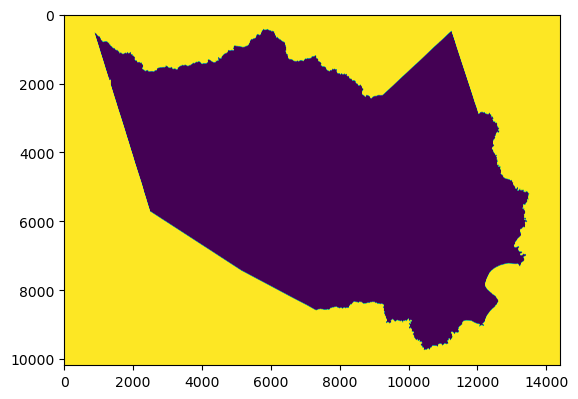

In [40]:
plt.imshow(image_with_rect)